In [16]:
import os
import pandas as pd

# Define the path to the data folder
data_folder = '5min_smoothed_data/'

# Initialize a variable to store the lengths of all data
all_lengths = []

# Loop through each CSV file in the folder
for filename in os.listdir(data_folder):
    if filename.endswith('.csv'):
        # Read the CSV file
        file_path = os.path.join(data_folder, filename)
        eeg_data = pd.read_csv(file_path)
        
        # Extract the 'spike hz' column data
        if 'spike hz' in eeg_data.columns:
            length = len(eeg_data['spike hz'])
            all_lengths.append(length)
        else:
            print(f"File {filename} does not have a 'spike hz' column.")

# Calculate the maximum and average lengths
max_length = max(all_lengths)
average_length = sum(all_lengths) / len(all_lengths)

print(f"Maximum data length: {max_length}")
print(f"Average data length: {average_length:.2f}")

Maximum data length: 1139
Average data length: 165.49


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim

In [17]:
import numpy as np
import pywt
from scipy.signal import welch

class EEGUtil:
    @staticmethod
    def load_data(file_path, column_name='BCI'):
        """Load EEG data from a CSV file."""
        data = pd.read_csv(file_path)
        signal = data[column_name].values
        return signal

    @staticmethod
    def padding(signal, target_length):
        """Pad or truncate signal to the target length."""
        if len(signal) < target_length:
            return np.pad(signal, (0, target_length - len(signal)), 'constant', constant_values=-1)
        return signal[:target_length]

    @staticmethod
    def wavelet_transform(signal):
        """Perform Wavelet Transform and extract features."""
        coeffs = pywt.wavedec(signal, 'db4', level=5)
        features = []
        for i in range(1, len(coeffs)):
            features.extend([np.mean(coeffs[i]), np.std(coeffs[i])])
        return np.array(features)

    @staticmethod
    def psd_transform(signal, fs=0.2, nperseg=128):
        """Perform Power Spectral Density analysis and extract features."""
        freqs, psd = welch(signal, fs=fs, nperseg=nperseg)
        return psd

In [18]:
from torch.utils.data import Dataset
import pandas as pd
import os
import torch

class EEGDataset(Dataset):
    def __init__(self, data_folder, target_length, strategy='padding'):
        self.data_folder = data_folder  # 數據文件夾路徑
        self.target_length = target_length  # 目標填充或截斷的長度
        self.strategy = strategy
        self.file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]  # 文件列表

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # 獲取當前文件名
        filename = self.file_list[idx]

        # 構建文件的完整路徑
        file_path = os.path.join(self.data_folder, filename)

        # 讀取 CSV 文件中的 EEG 數據
        if os.path.isfile(file_path):
            signal = EEGUtil.load_data(file_path)
        else:
            raise FileNotFoundError(f"文件 {file_path} 不存在。")

        # 根據指定策略對數據進行處理
        if self.strategy == 'padding':
            processed_signal = EEGUtil.padding(signal, self.target_length)
        elif self.strategy == 'wavelet':
            processed_signal = EEGUtil.wavelet_transform(signal)
        elif self.strategy == 'psd':
            processed_signal = EEGUtil.psd_transform(signal)
        else:
            raise ValueError("Invalid processing strategy")
        
        # 增加通道維度，使得最終數據形狀為 [1, target_length]
        processed_signal = np.expand_dims(processed_signal, axis=0)

        # 打印數據形狀以檢查
        #print(f"Processed signal shape: {processed_signal.shape}")

        # 這裡我們假設類別是根據文件名或某種邏輯進行判斷的，如果有其他邏輯，可以在此處修改
        class_id = 0  # 你可以根據需要設置類別 ID

        return torch.tensor(processed_signal, dtype=torch.float32), class_id

In [19]:
initial_channels = 128
class CNNEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNEncoder, self).__init__()
        self.latent_dim = latent_dim

        layers = [
            nn.Conv1d(1, initial_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU()
        ]

        in_channels = initial_channels
        for i in range(3):  # 3 more layers to make 4 in total
            out_channels = in_channels // 2
            layers.extend([
                nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)
        self.fc_mean = nn.Linear(in_channels * seq_length, latent_dim)
        self.fc_logvar = nn.Linear(in_channels * seq_length, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

class CNNDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, initial_channels // 8 * seq_length)  # Match the output channel of the encoder

        layers = [nn.LeakyReLU()]
        in_channels = initial_channels // 8
        for i in range(3):
            out_channels = in_channels * 2
            layers.extend([
                nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU()
            ])
            in_channels = out_channels
        
        # Remove the last LeakyReLU and add a final ConvTranspose to match the Encoder's starting channel
        layers.pop()
        layers.append(nn.ConvTranspose1d(in_channels, 1, kernel_size=3, stride=1, padding=1))

        self.decoder = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), initial_channels // 8, seq_length)
        x = self.decoder(x)
        return F.leaky_relu(x)


class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = CNNEncoder(latent_dim)
        self.decoder = CNNDecoder(latent_dim)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decoder(z)
        return reconstruction, mean, logvar
    
    def get_embedding(self, x):
        self.eval()
        with torch.no_grad():
            mean, logvar = self.encoder(x)
            z = self.reparameterize(mean, logvar)
        return z

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [23]:
def train(model, dataloader, optimizer, criterion, alpha, kl_loss_enabled=True):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for data, _ in dataloader:  # We don't use the labels during unsupervised training for VAE
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass through the model
        reconstruction, mean, logvar = model(data)

        # Compute the reconstruction loss (mean squared error)
        recon_loss = criterion(reconstruction, data)

        # Compute the KL divergence loss
        kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())

        # Combine the losses
        loss = recon_loss + (alpha * kl_loss if kl_loss_enabled else 0)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)  # Accumulate the total loss for this batch

    epoch_loss = running_loss / len(dataloader.dataset)  # Calculate the average loss per sample
    return epoch_loss


def test(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for data, _ in dataloader:  # 注意：解包数据，将信号和标签分别取出
            data = data.to(device)
            reconstruction, _, _ = model(data)
            loss = criterion(reconstruction, data)
            running_loss += loss.item() * data.size(0)
    return running_loss / len(dataloader.dataset)

def get_latent_variables(model, dataloader):
    model.eval()
    all_latent_vars = []
    with torch.no_grad():
        for data, _  in dataloader:
            data = data.to(device)
            _, mean, _ = model(data)
            all_latent_vars.append(mean.detach().cpu())
    return torch.cat(all_latent_vars)

Epoch 1/100, Train Loss: 0.7957, Test Loss: 0.6842
Epoch 2/100, Train Loss: 0.5805, Test Loss: 0.3702
Epoch 3/100, Train Loss: 0.3712, Test Loss: 0.3361
Epoch 4/100, Train Loss: 0.3471, Test Loss: 0.3209
Epoch 5/100, Train Loss: 0.3345, Test Loss: 0.3151
Epoch 6/100, Train Loss: 0.3275, Test Loss: 0.3063
Epoch 7/100, Train Loss: 0.3209, Test Loss: 0.2655
Epoch 8/100, Train Loss: 0.2894, Test Loss: 0.2791
Epoch 9/100, Train Loss: 0.2745, Test Loss: 0.2478
Epoch 10/100, Train Loss: 0.3071, Test Loss: 0.2898
Epoch 11/100, Train Loss: 0.2600, Test Loss: 0.2081
Epoch 12/100, Train Loss: 0.2141, Test Loss: 0.1852
Epoch 13/100, Train Loss: 0.1866, Test Loss: 0.1552
Epoch 14/100, Train Loss: 0.1565, Test Loss: 0.1356
Epoch 15/100, Train Loss: 0.1453, Test Loss: 0.1215
Epoch 16/100, Train Loss: 0.1304, Test Loss: 0.1110
Epoch 17/100, Train Loss: 0.1154, Test Loss: 0.0900
Epoch 18/100, Train Loss: 0.0934, Test Loss: 0.0781
Epoch 19/100, Train Loss: 0.0811, Test Loss: 0.0711
Epoch 20/100, Train L

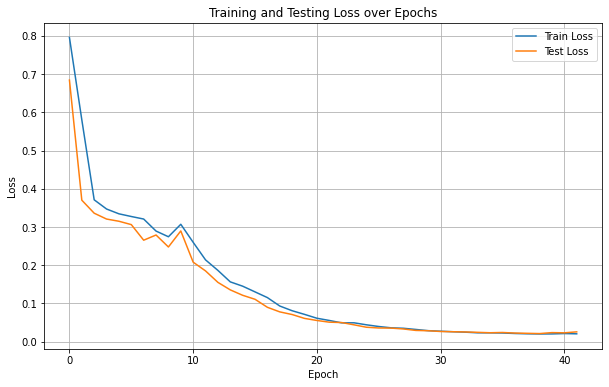

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd

# 設置設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 超參數設置
latent_dim = 10  # 潛在空間的維度
initial_channels = 128  # CNN 的初始通道數
#seq_length = 1139  # 填充或截斷的序列長度 此處設為最長
seq_length = 600  # 填充或截斷的序列長度 此處設為最長
batch_size = 32
epochs = 100
alpha = 1e-6  # KL 損失的權重
patience = 3  # 定义在多少个 epoch 不改善后停止训练

# 定義數據文件夾路徑
data_folder = '5min_smoothed_data/'  # 替換為你實際的數據文件夾路徑

# 創建 EEG 數據集和數據加載器
eeg_dataset = EEGDataset(data_folder, target_length=seq_length, strategy='padding')
train_size = int(0.8 * len(eeg_dataset))
test_size = len(eeg_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(eeg_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# 定义模型、损失函数和优化器
vae_model = VAE(latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3, weight_decay=1e-4)

# 训练和测试损失列表，用于绘制曲线
train_losses = []
test_losses = []

# 早停相关变量
best_test_loss = float('inf')
epochs_no_improve = 0

# 训练循环
for epoch in range(epochs):
    train_loss = train(vae_model, train_loader, optimizer, criterion, alpha)
    test_loss = test(vae_model, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    # 检查早停条件
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print("Validation loss has not improved for {} epochs. Early stopping...".format(patience))
        break
        
        
# 绘制训练和测试损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [24]:
# 推断步骤以提取嵌入
latent_embeddings = get_latent_variables(vae_model, test_loader)
print("推断完成。潜在嵌入的形状：", latent_embeddings.shape)

推断完成。潜在嵌入的形状： torch.Size([108, 10])


In [28]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 第一步：訓練 VAE（參照之前的 VAE 訓練代碼）

# 第二步：提取具有標註數據的潛在特徵
def extract_latent_features(vae_model, outcome_file, data_folder, seq_length):
    # 讀取標註數據
    outcome_data = pd.read_csv(outcome_file)
    outcome_dict = outcome_data.set_index('pat_ID')['outcome'].to_dict()

    latent_features = []
    labels = []

    # 遍歷帶有標註的數據文件
    for filename in os.listdir(data_folder):
        if filename.endswith('.csv'):
            patient_id = filename.split('.')[0]

            if patient_id in outcome_dict:
                file_path = os.path.join(data_folder, filename)
                signal = EEGUtil.load_data(file_path, column_name='BCI')  # 假設'BCI'是數據列名

                # 根據需要的策略處理信號（這裡假設為 padding）
                processed_signal = EEGUtil.padding(signal, seq_length)
                processed_signal = np.expand_dims(processed_signal, axis=0)
                processed_signal = torch.tensor(processed_signal, dtype=torch.float32).to(device)

                # 使用訓練好的 VAE 獲取潛在表示
                with torch.no_grad():
                    latent_vector = vae_model.get_embedding(processed_signal.unsqueeze(0)).cpu().numpy()
                latent_features.append(latent_vector.flatten())

                # 取得對應的 outcome 並轉為標籤（0 或 1）
                outcome = outcome_dict[patient_id]
                labels.append(1 if outcome == 'Good Outcome' else 0)

    return np.array(latent_features), np.array(labels)

# 提取特徵和標籤
latent_features, labels = extract_latent_features(vae_model, 'valid_patients_outcome.csv', data_folder, seq_length)

# 第三步：使用提取的特徵進行 SVM 分類
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(latent_features, labels)

# 評估分類器性能
predicted_labels = svm_classifier.predict(latent_features)
accuracy = accuracy_score(labels, predicted_labels)
print(f'SVM 分類準確率: {accuracy:.2f}')

SVM 分類準確率: 0.83
